In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import strategy.trendlabeling as tlb
import numpy as np
import datetime

import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import afml.util.multiprocess as mul
import features.bars as bars  

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

1. Import Dataset

In [2]:
df_yf = gd.get_yf_data(tickers= "SPY AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  5 of 5 completed


In [3]:
df = df_yf[df_yf['Ticker'] == 'ALGM']

In [4]:
fig = go.Figure(data=go.Candlestick(x=df.index,
                    open=df.Open,
                    high=df.High,
                    low=df.Low,
                    close=df['Adj Close']))
fig.show()

2. Form Dollar Bars

In [5]:
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

In [6]:
# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
ans = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = ans.close.copy()

In [7]:
fig = go.Figure(data=go.Candlestick(x=ans.index,
                    open=ans['open'],
                    high=ans['high'],
                    low=ans['low'],
                    close=ans['close']))
fig.show()

3. Run cusum filter to get std dev of daily returns at equal threshold

In [8]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

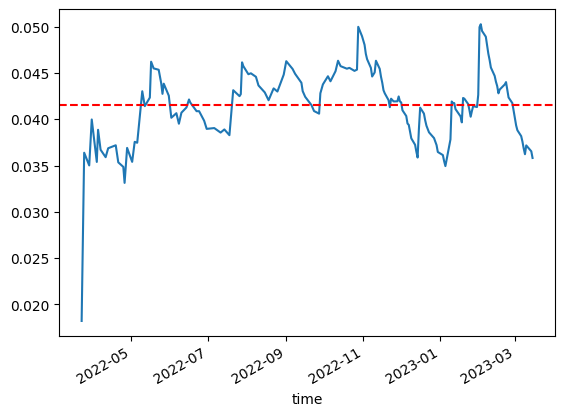

In [9]:
# show volitility over time

f,ax=plt.subplots()
dailyVolatility.plot(ax=ax)
ax.axhline(dailyVolatility.mean(),ls='--',color='r')

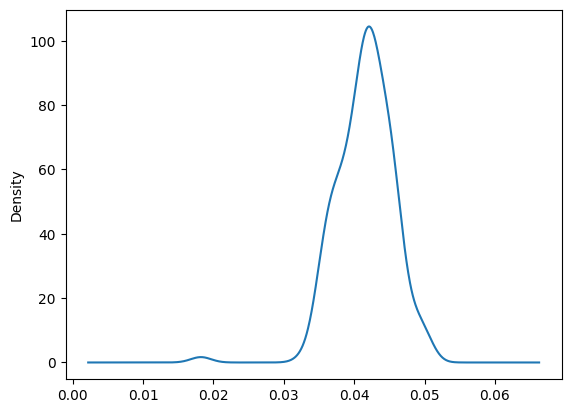

In [10]:
#show distribution of volitility
ax = dailyVolatility.plot.kde()

In [11]:
# apply cusum filter
tEvents = flt.getTEvents(close,h=dailyVolatility.mean())
tEvents

DatetimeIndex(['2022-03-18', '2022-03-22', '2022-03-23', '2022-03-25',
               '2022-03-29', '2022-03-31', '2022-04-04', '2022-04-05',
               '2022-04-07', '2022-04-11',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06',
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
               '2023-03-14', '2023-03-15'],
              dtype='datetime64[ns]', length=156, freq=None)

4. Add vertical barrier a.k.a. event end date

In [12]:
# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)
t1

2022-03-18   2022-03-29
2022-03-22   2022-04-04
2022-03-23   2022-04-04
2022-03-25   2022-04-04
2022-03-29   2022-04-11
                ...    
2023-02-27   2023-03-09
2023-02-28   2023-03-10
2023-03-01   2023-03-14
2023-03-02   2023-03-14
2023-03-03   2023-03-14
Name: time, Length: 149, dtype: datetime64[ns]

5. Apply Triple Barrier method where ptSl = [2,1]  (2 to 1 profit ratio). Getting the Time of the First Touch, with Meta Labels

In [13]:
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=None).dropna()

print(events)

                   t1      trgt  pt  sl
2022-03-23 2022-03-29  0.018217   2   1
2022-03-25 2022-04-04  0.036385   2   1
2022-03-29 2022-04-05  0.035012   2   1
2022-03-31 2022-04-07  0.039976   2   1
2022-04-04 2022-04-07  0.035391   2   1
...               ...       ...  ..  ..
2023-02-27 2023-03-09  0.041744   2   1
2023-02-28 2023-03-10  0.040923   2   1
2023-03-01 2023-03-14  0.040124   2   1
2023-03-02 2023-03-14  0.039333   2   1
2023-03-03 2023-03-14  0.038813   2   1

[147 rows x 4 columns]


c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



6. Labeling for Side & Size with Meta Labels by generating outcome label using getBins

In [14]:
labels = tbar.get_bins(triple_barrier_events = events, close=close)

In [15]:
print(labels)
print(labels.bin.value_counts())

                 ret      trgt  bin
2022-03-23  0.061462  0.018217    1
2022-03-25 -0.035641  0.036385    0
2022-03-29 -0.116805  0.035012   -1
2022-03-31 -0.105282  0.039976   -1
2022-04-04 -0.097015  0.035391   -1
...              ...       ...  ...
2023-02-27  0.053343  0.041744    0
2023-02-28  0.008700  0.040923    0
2023-03-01  0.031757  0.040124    0
2023-03-02  0.022182  0.039333    0
2023-03-03 -0.005286  0.038813    0

[147 rows x 3 columns]
 0    81
 1    35
-1    31
Name: bin, dtype: int64


7. Drop underpopulated labels (snippet 3.8) by eliminating rare observations

In [16]:
clean_labels  = tbar.drop_labels(labels)
print(clean_labels)

                 ret      trgt  bin
2022-03-23  0.061462  0.018217    1
2022-03-25 -0.035641  0.036385    0
2022-03-29 -0.116805  0.035012   -1
2022-03-31 -0.105282  0.039976   -1
2022-04-04 -0.097015  0.035391   -1
...              ...       ...  ...
2023-02-27  0.053343  0.041744    0
2023-02-28  0.008700  0.040923    0
2023-03-01  0.031757  0.040124    0
2023-03-02  0.022182  0.039333    0
2023-03-03 -0.005286  0.038813    0

[147 rows x 3 columns]


In [17]:
clean_labels.bin.value_counts()

 0    81
 1    35
-1    31
Name: bin, dtype: int64

## Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [18]:
import afml.sampling.concurrent as cur
import afml.sample_weights.attribution as atr

In [20]:
close

time
2022-03-17    28.250000
2022-03-18    29.500000
2022-03-22    29.070000
2022-03-23    28.309999
2022-03-25    29.180000
                ...    
2023-03-08    46.029999
2023-03-09    45.220001
2023-03-10    44.060001
2023-03-14    45.160000
2023-03-15    44.470001
Name: close, Length: 168, dtype: float64

In [19]:
# compute the number of concurrent events per bar.
numCoEvents = mul.mp_pandas_obj(cur.num_concurrent_events,('molecule', events.index),                         
                              cpus, close_series_index=close.index, label_endtime=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()

# Estimating the Average Uniqueness of a Label
out['tW'] = mul.mp_pandas_obj(cur._get_average_uniqueness,('molecule', events.index),
                            cpus,label_endtime=events['t1'],num_conc_events=numCoEvents)

# Determination of Sample Weight by Absolute Return Attribution

out['w']=mul.mp_pandas_obj(atr._apply_weight_by_return,('molecule', events.index),cpus,
                         label_endtime= events.index,num_conc_events=numCoEvents,close_series=close)
out['w']*=out.shape[0]/out['w'].sum()

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:31: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:113: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\sampling\concurrent.py:48: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

c:\Users\choit\OneDrive\Coursera\S

 0.043297    1
 0.024846    1
 0.001231    1
 0.014955    1
-0.015878    1
            ..
 0.037034    1
-0.073807    1
-0.073784    1
 0.017071    1
-0.015397    1
Name: close, Length: 167, dtype: int64 Series([], dtype: int64)


AttributeError: 'DatetimeIndex' object has no attribute 'loc'

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
out.reset_index(drop=True).plot(subplots=True, alpha=0.5, ax=ax);